# What is **Regression Analysis**
A statistical technique used to investigate the relationship between a dependent variable (target/label) and one or more independent variables (features).

<div><br></div>

### **Typical architecture of a regression neural network**
There are many different ways but this is a generic setup.



| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) / Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

> **Source** <br> *Page 293 of [Hands-On Machine Learning Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

In [ ]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Last run...
import datetime as dt
print(f"Notebook last run: {dt.datetime.now()}")

Notebook last run: 2024-01-06 08:21:33.558957


# Get the **data**
The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/9/auto+mpg).

* The purpose of the data is to predict fuel efficiency (miles per gallon, or MPG) of automobiles based on various attributes.

* Originally derived from the 1983 American Statistical Association Exposition.

In [ ]:
# download and import the data using pandas
data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']

raw_dataset = pd.read_csv(data_url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
raw_dataset.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1

> **Origins**:
* *1 for USA*
* *2 for Europe*
* *3 for Japan*

In [ ]:
# take a copy from the data
df = raw_dataset.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


# Data **Preparation**


In [ ]:
# get missing values
def get_missing_value_counts(data_frame):
    missing_counts = data_frame.isnull().sum()
    missing_columns = missing_counts[missing_counts > 0]
    return missing_columns

missing_values_table = get_missing_value_counts(df)
missing_values_table

horsepower    6
dtype: int64

In [ ]:
# drop the nan value rows
df = df.dropna()

In [ ]:
# split the data into training and test set
train = df.sample(frac=0.8, random_state=7)
test = df.drop(train.index)
print(train.shape, test.shape)

(314, 8) (78, 8)


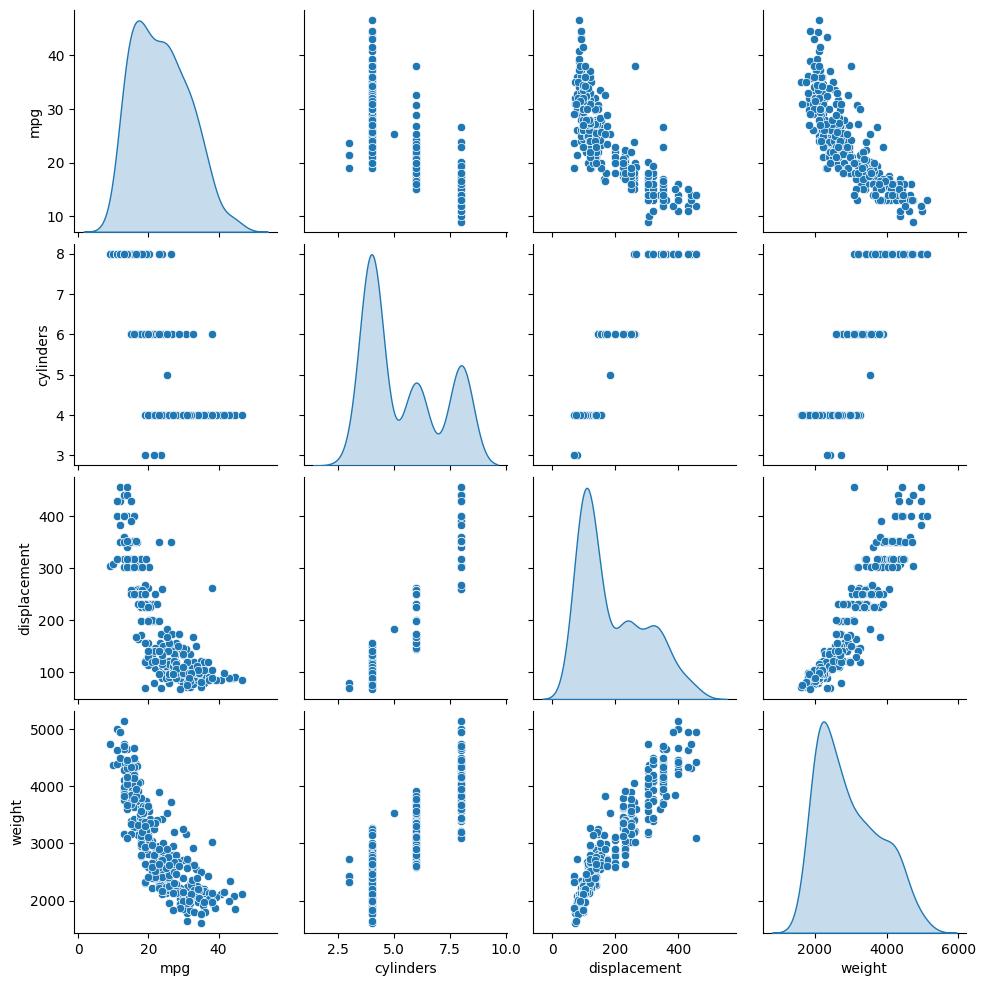

In [ ]:
# pairplot
sns.pairplot(train[['mpg', 'cylinders', 'displacement', 'weight']], diag_kind='kde')

In [ ]:
# split features from labels
X = df.drop('mpg', axis=1)
y = df['mpg']

X_train = train.drop('mpg', axis=1)
X_test = test.drop('mpg', axis=1)

y_train = train['mpg']
y_test = test['mpg']

print('splitting compeleted successfully!')

splitting compeleted successfully!


# **Normalize** numerical data
The formula for noramlization to a scale between one and zero is:
<br>

## $ \frac{value - min}{max - min} $

In [ ]:
# Normalizing the features X
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

print("Normalization is done!")

Normalization is done!


# Linear regression **with multiple variables**

In [ ]:
# Model building

linear_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[7, ]),
    layers.Dense(units=1)
])

# add optimizer and loss function
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [ ]:
%%time
history = linear_model.fit(
    X_train, y_train,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: user 3.46 s, sys: 169 ms, total: 3.63 s
Wall time: 3.77 s


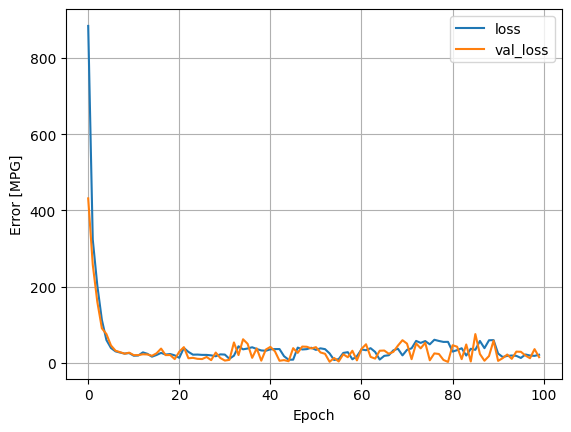

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

In [ ]:
# collect the test results for later
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    X_test, y_test, verbose=0
)

# Regression **with a deep neural network** *(*DNN*)*

In [ ]:
## build the model
dnn_model = keras.Sequential([
    layers.InputLayer(input_shape=[7, ]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)

In [ ]:
%%time
history = dnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100, verbose=0
)

CPU times: user 4.42 s, sys: 172 ms, total: 4.6 s
Wall time: 5.58 s


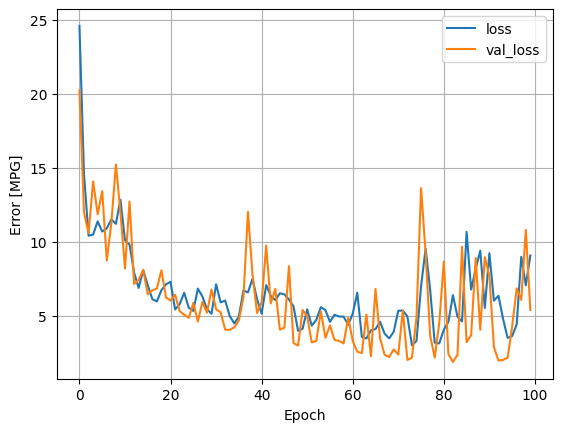

In [ ]:
plot_loss(history)

In [ ]:
# collect the results on the test set
test_results['dnn_model'] = dnn_model.evaluate(X_test, y_test, verbose=0)

# Performance

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T


Mean absolute error [MPG]
horsepower_model                   3.882807
linear_model                      14.203972
dnn_model                          6.356443

3/3 [==============================] - 0s 4ms/step


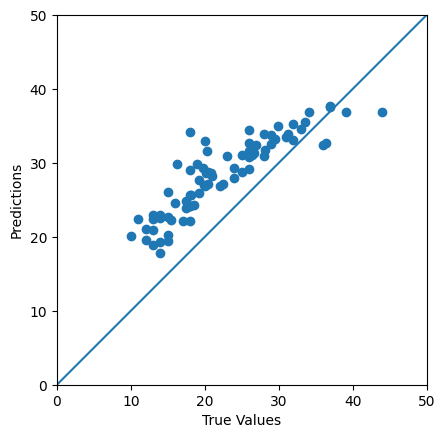

In [ ]:
# make predictions with dnn model

test_predictions = dnn_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.xlim([0, 50])
plt.ylim([0, 50])
_ = plt.plot([0, 50], [0, 50])